#Training for GTSRB


In [1]:
!pip install kaggle
!mkdir ~/.kaggle

In [2]:
with open("/root/.kaggle/kaggle.json", "w+") as f: f.write('{"username":"","key":""}')
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
!unzip gtsrb-german-traffic-sign.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00010.png  
  inflating: train/5/00005_00053_00011.png  
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  in

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import Dataset
from PIL import Image

class GTSRB_Dataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
      self.data_frame = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transform

    def __len__(self):
      return len(self.data_frame)

    def __getitem__(self, idx):
      img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 7])
      image = Image.open(img_name)
      label = self.data_frame.iloc[idx, 6]
      if self.transform:
        image = self.transform(image)
      return image, label

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

train_dataset = GTSRB_Dataset(csv_file='/content/Train.csv', root_dir='/content/', transform=transform)
test_dataset = GTSRB_Dataset(csv_file='/content/Test.csv', root_dir='/content/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

In [27]:
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 43)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

model = MLP().to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    loss_values = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

    # Plotting the loss over epochs
    plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Function Over Epochs')
    plt.legend()
    plt.show()

Using cpu device
MLP(
  (layers): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=43, bias=True)
  )
)


In [15]:
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs):
    train_losses = []
    test_losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            train_loss = criterion(outputs, labels)

            train_loss.backward()
            optimizer.step()

            running_train_loss += train_loss.item()

        train_losses.append(running_train_loss / len(train_loader))

        model.eval()
        running_test_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                test_loss = criterion(outputs, labels)
                running_test_loss += test_loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_losses.append(running_test_loss / len(test_loader))
        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

    return train_losses, test_losses, accuracies

Epoch [1/12], Train Loss: 1.9702, Test Loss: 1.5608, Accuracy: 56.59%
Epoch [2/12], Train Loss: 0.8510, Test Loss: 1.0602, Accuracy: 73.74%
Epoch [3/12], Train Loss: 0.5916, Test Loss: 1.1104, Accuracy: 74.28%
Epoch [4/12], Train Loss: 0.4664, Test Loss: 0.9757, Accuracy: 78.23%
Epoch [5/12], Train Loss: 0.3995, Test Loss: 0.8842, Accuracy: 80.54%
Epoch [6/12], Train Loss: 0.3218, Test Loss: 0.9924, Accuracy: 78.17%
Epoch [7/12], Train Loss: 0.2910, Test Loss: 0.9302, Accuracy: 82.85%
Epoch [8/12], Train Loss: 0.2614, Test Loss: 1.1666, Accuracy: 81.47%
Epoch [9/12], Train Loss: 0.2258, Test Loss: 1.1540, Accuracy: 80.53%
Epoch [10/12], Train Loss: 0.2323, Test Loss: 1.0086, Accuracy: 82.91%
Epoch [11/12], Train Loss: 0.1973, Test Loss: 0.9833, Accuracy: 82.38%
Epoch [12/12], Train Loss: 0.1866, Test Loss: 0.9201, Accuracy: 84.30%


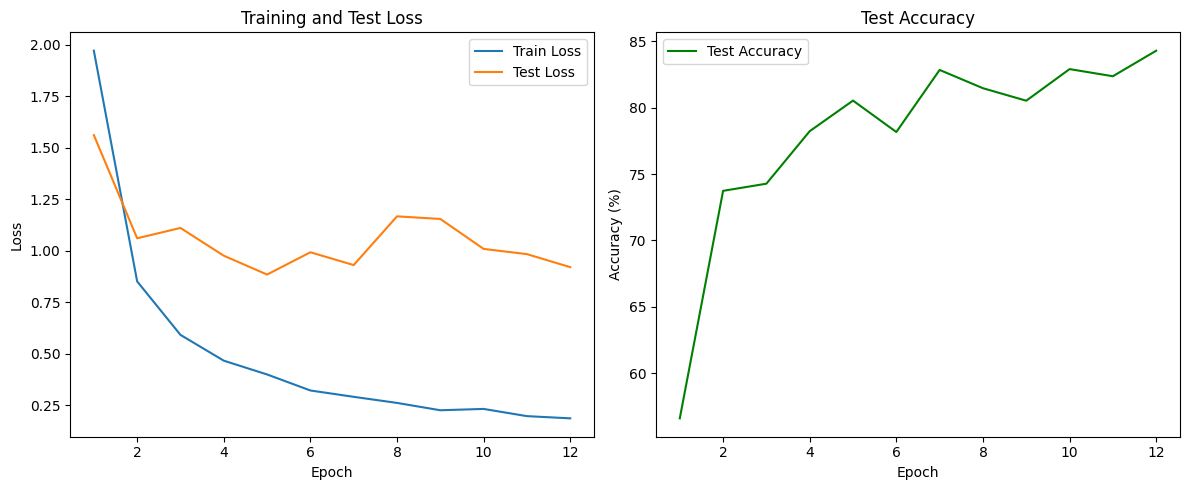

In [28]:
# Run training and evaluation with plots
epochs = 12
train_losses, test_losses, accuracies = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=epochs)

# Plot Train and Test Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()